# Keras deep learning

## Regression models

### 4 steps for modeling process
1. Specify architechture (how many layers, how many nodes in each layer, which activation function to use)
2. Compile (loss function and details about optimization)
3. Fit model (cycle of backpropagation and optimization of model weights)
4. Use model for predictions

In [639]:
import numpy as np
import tensorflow 
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [640]:
data = pd.read_excel('work/hourly_wages.xlsx')

In [641]:
data.head()

,wage_per_hour,union,education_yrs,experience_yrs,age,female,marr,south,manufacturing,construction
0,5.10,0,8,21,35,1,1,0,1,0
1,4.95,0,9,42,57,1,1,0,1,0
2,6.67,0,12,1,19,0,0,0,1,0
3,4.00,0,12,4,22,0,0,0,0,0
4,7.50,0,12,17,35,0,1,0,0,0


In [52]:
predictors = np.array(data.iloc[:, 1:])
n_cols = predictors.shape[1] # number of nodes in the input layer
target = np.array(data['wage_per_hour'])

In [55]:
# sequential models require that each layer has only weights or 
# connections only to one layer coming to them in the network diagram

model = keras.Sequential() # build model ()

### This model has two hidden layers and an output layer

We start adding layers. Standard layer type is called dense is most common.
It simply means that all the nodes in the previous layer are connected to all nodes in current layer.

In [59]:
# first arg is nr of nodes
# the comma after n_cols is an indicator that data can have any nr of rows (datapoints)
model.add(keras.layers.Dense(100, activation='relu', input_shape = (n_cols,))) 
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1)) # output layer

### Compiling the model

1. Specify optimizer (learning rate). Few algos but quite complex. "Adam" algo is good choice, it adjusts the learning rate as it does gradient descent to ensure reasonable values throughout the optimization process
2. Loss function. mean_squared_error common for regression problems

In [60]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Fitting the model

Applying backpropagation and gradient descent with data to update the weights

Scaling data before fitting can help optimization




In [61]:
model.fit(predictors, target)

Train on 534 samples
534/534 [==============================] - 1s 992us/sample - loss: 47.3283


## Classification models

I use 'categorical_crossentropy' instead of mean squared error. Similar to log loss in that lower is better. 
I add metrics=['accuracy'] to compile easier diagnostics. 
In contrast to above, output layer naturally has more nodes (one for each outcome). Also uses 'softmax' activation (results as propabilities). 

One-hot encoding for categorical outcome variable. 

### Read data

In [500]:
df = pd.read_excel('work/titanic_full.xlsx')
df = df.drop(['name', 'ticket', 'cabin', 'home.dest'], axis=1)
print(df.shape)
df.head()

(1309, 8)


,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0,0,0,211.3375,S
1,1,1,male,NaN,1,2,151.5500,S
2,1,0,female,2.0,1,2,151.5500,S
3,1,0,male,30.0,1,2,151.5500,S
4,1,0,female,25.0,1,2,151.5500,S


### Make dummies and modify data

In [516]:
df1 = pd.get_dummies(df, dummy_na=False)
df1['age_was_missing'] = np.where(df1['age'].isna() == True, 1, 0)
df1 = df1.dropna()

### Modify age

In [517]:
without_outliers = df1[df1['age'] < 120]
age_mean = without_outliers['age'].mean()
df1['age'] = np.where(df1['age'] > 120, age_mean, df1['age'])
df1.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,age_was_missing
0,1,1,29.0,0,0,211.3375,1,0,0,0,1,0
2,1,0,2.0,1,2,151.5500,1,0,0,0,1,0
3,1,0,30.0,1,2,151.5500,0,1,0,0,1,0
4,1,0,25.0,1,2,151.5500,1,0,0,0,1,0
5,1,1,48.0,0,0,26.5500,0,1,0,0,1,0


In [528]:
predictors = df1.drop('survived', axis=1) # drop na

(array([ 71.,  59., 268., 259., 161., 108.,  65.,  40.,  10.,   3.]),
 array([ 0.17 ,  8.153, 16.136, 24.119, 32.102, 40.085, 48.068, 56.051,
        64.034, 72.017, 80.   ]),
 <a list of 10 Patch objects>)

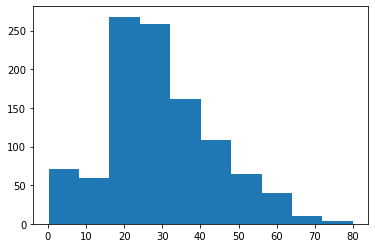

In [529]:
plt.hist(predictors['age'])

### Normalize data

In [530]:
from sklearn import preprocessing
#colnames = predictors.columns
colnames = ['age_scaled', 'fare_scaled']
scaler = preprocessing.StandardScaler()
scaled_predictors = pd.DataFrame(scaler.fit_transform(predictors[['age', 'fare']]), columns=colnames)

In [531]:
#reset index 
scaled_predictors = scaled_predictors.reset_index(drop=True)
predictors = predictors.reset_index(drop=True)
predictors = predictors.join(scaled_predictors)

### Drop either scaled or unscaled age and fare

In [532]:
predictors = predictors.drop(['age', 'fare'], axis=1)
#predictors = predictors.drop(['age_scaled', 'fare_scaled'], axis=1)

### Split between training and testing data

In [533]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(predictors, df1['survived'], test_size=0.20)
#train_X, test_X, train_Y, test_Y = train_test_split(scaled_predictors, df1['survived'], test_size=0.25)

In [534]:
# Ensure training dataset has only % of original X data
print(train_X.shape[0] / df1.shape[0])
# Ensure testing dataset has only % of original X data
print(test_X.shape[0] / df1.shape[0])

0.7998084291187739
0.20019157088122605


In [535]:
target_train = keras.utils.to_categorical(train_Y)
predictors_train = np.array(train_X)
n_cols = df1.shape[1] - 1

### Build the model

In [571]:
# Set up the model
model = keras.Sequential()

# Add the first layer
model.add(keras.layers.Dense(100, activation='relu', input_shape=(n_cols,)))

#model.add(keras.layers.Dense(1000, activation='relu', input_shape=(n_cols,)))

#model.add(keras.layers.Dense(1000, activation='relu', input_shape=(n_cols,)))

# Add the output layer
model.add(keras.layers.Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
#model.fit(predictors_train, target_train)
model.fit(predictors_train, target_train, epochs=100, batch_size=len(predictors_train))


Train on 835 samples
Epoch 1/100
835/835 [==============================] - 0s 586us/sample - loss: 0.7600 - accuracy: 0.3617
Epoch 2/100
835/835 [==============================] - 0s 8us/sample - loss: 0.7486 - accuracy: 0.3557
Epoch 3/100
835/835 [==============================] - 0s 9us/sample - loss: 0.7387 - accuracy: 0.3749
Epoch 4/100
835/835 [==============================] - 0s 9us/sample - loss: 0.7299 - accuracy: 0.3760
Epoch 5/100
835/835 [==============================] - 0s 12us/sample - loss: 0.7221 - accuracy: 0.4000
Epoch 6/100
835/835 [==============================] - 0s 7us/sample - loss: 0.7151 - accuracy: 0.4024
Epoch 7/100
835/835 [==============================] - 0s 10us/sample - loss: 0.7089 - accuracy: 0.4168
Epoch 8/100
835/835 [==============================] - 0s 10us/sample - loss: 0.7033 - accuracy: 0.4335
Epoch 9/100
835/835 [==============================] - 0s 9us/sample - loss: 0.6982 - accuracy: 0.4563
Epoch 10/100
835/835 [=========================

Epoch 80/100
835/835 [==============================] - 0s 9us/sample - loss: 0.5848 - accuracy: 0.7222
Epoch 81/100
835/835 [==============================] - 0s 8us/sample - loss: 0.5839 - accuracy: 0.7234
Epoch 82/100
835/835 [==============================] - 0s 8us/sample - loss: 0.5831 - accuracy: 0.7281
Epoch 83/100
835/835 [==============================] - 0s 21us/sample - loss: 0.5822 - accuracy: 0.7293
Epoch 84/100
835/835 [==============================] - 0s 12us/sample - loss: 0.5814 - accuracy: 0.7305
Epoch 85/100
835/835 [==============================] - 0s 9us/sample - loss: 0.5805 - accuracy: 0.7353
Epoch 86/100
835/835 [==============================] - 0s 8us/sample - loss: 0.5797 - accuracy: 0.7377
Epoch 87/100
835/835 [==============================] - 0s 8us/sample - loss: 0.5789 - accuracy: 0.7425
Epoch 88/100
835/835 [==============================] - 0s 9us/sample - loss: 0.5781 - accuracy: 0.7425
Epoch 89/100
835/835 [==============================] - 0s 13u

## Using models for prediction

### Actual prediction

In [645]:
predictors_test = np.array(test_X)

# Calculate predictions: predictions
predictions = model.predict(predictors_test)

#predictions_res = model.predict_classes(predictors_test)
# Calculate predicted probability of survival: predicted_prob_true
predicted_prob_true = predictions[:,1]

# print predicted_prob_true
print(predicted_prob_true[0:20])

[0.86237997 0.77152324 0.77392787 0.5865409  0.49318233 0.56668174
 0.5592997  0.56911767 0.8718145  0.43864974 0.7831808  0.5772773
 0.5138588  0.57644546 0.7748149  0.50241506 0.14476067 0.48253796
 0.46459648 0.4776221 ]


# Evaluating results (traditional scikit learn + Keras)

### Accuracy, precision, recall

In [599]:
test_accuracy = round(accuracy_score(test_Y, predictions_res), 4)
test_precision = round(precision_score(test_Y, predictions_res), 4)
test_recall = round(recall_score(test_Y, predictions_res), 4)

print('Test accuracy: {}, Test precision: {}, Test recall: {}' .format(test_accuracy, test_precision, test_recall))

Test accuracy: 0.7321, Test precision: 0.907, Test recall: 0.4286


### ROC curves

In [611]:
# calculate AUC
auc = roc_auc_score(test_Y, predictions_res)
print('AUC: %.3f' % auc)

AUC: 0.697


In [613]:
# Get the baseline
ns_probs = [0 for _ in range(len(test_Y))]
ns_auc = roc_auc_score(test_Y, ns_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.697


In [614]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_Y, ns_probs)
fpr, tpr, _ = roc_curve(test_Y, predictions_res)

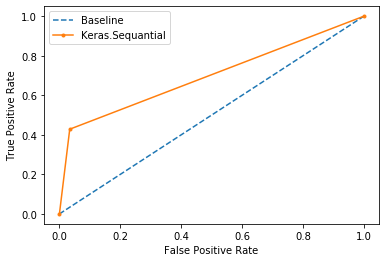

In [615]:
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
plt.plot(fpr, tpr, marker='.', label='Keras.Sequential')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Model optimization
## how to choose model architechture and optimization arguments

In [632]:
def get_new_model():
    ''' Function for creating a new model '''
    model = keras.Sequential()
    model.add(keras.layers.Dense(100, activation='relu', input_shape=(n_cols,)))
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))
    return(model)

Too small learning rates can cause a model to not improve in a significant way and too large might take us too far. 
Easiest way to see effect of different learning rates is to use the simplest optimizer - stochastic gradient descent

In [633]:
lr_to_test = [.000001, 0.01, 1]

In the loop I compile the model with SGD using a different learning rate. 
This replaces the previously used 'adam' optimizer. 

K-fold cross-validation used here, even though computational expense might be large for bigger datasets. 

Early stopping is used also.Patience means how many epochs do we go through before we stop training the model - 2 or 3 are often reasonable values for it. By default Keras trains for 10 epochs. With a smart logic we can set a higher or lower number of epochs as needed, and the model will stop once the validation loss stops improving.

In [652]:
early_stopping_monitor = keras.callbacks.EarlyStopping(patience=2)

for lr in lr_to_test:
    print('\n\nTesting model with learning rate: %f\n'%lr )
    model = get_new_model()
    my_optimizer = keras.optimizers.SGD(lr=lr)
    model.compile(optimizer=my_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(predictors_train, target_train, 
              epochs=20,
              callbacks=[early_stopping_monitor],
              validation_split=0.3)



Testing model with learning rate: 0.000001

Train on 584 samples, validate on 251 samples
Epoch 1/20
584/584 [==============================] - 1s 2ms/sample - loss: 0.6934 - accuracy: 0.5479 - val_loss: 0.6962 - val_accuracy: 0.5697
Epoch 2/20
584/584 [==============================] - 0s 236us/sample - loss: 0.6934 - accuracy: 0.5479 - val_loss: 0.6961 - val_accuracy: 0.5697
Epoch 3/20
584/584 [==============================] - 0s 228us/sample - loss: 0.6934 - accuracy: 0.5479 - val_loss: 0.6961 - val_accuracy: 0.5697
Epoch 4/20
584/584 [==============================] - 0s 240us/sample - loss: 0.6934 - accuracy: 0.5479 - val_loss: 0.6961 - val_accuracy: 0.5697
Epoch 5/20
584/584 [==============================] - 0s 233us/sample - loss: 0.6934 - accuracy: 0.5479 - val_loss: 0.6961 - val_accuracy: 0.5697
Epoch 6/20
584/584 [==============================] - 0s 238us/sample - loss: 0.6933 - accuracy: 0.5479 - val_loss: 0.6961 - val_accuracy: 0.5697
Epoch 7/20
584/584 [==============

## Comparison of different models

Create the first model with some specific attributes

In [657]:
model_1 = keras.Sequential()
model_1.add(keras.layers.Dense(30, activation='relu', input_shape=(n_cols,)))
model_1.add(keras.layers.Dense(10, activation='relu'))
model_1.add(keras.layers.Dense(2, activation='softmax'))
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Create the second model

In [658]:
model_2 = keras.Sequential()
model_2.add(keras.layers.Dense(1000, activation='relu', input_shape=(n_cols,)))
model_2.add(keras.layers.Dense(100, activation='relu'))
model_2.add(keras.layers.Dense(50, activation='relu'))
model_2.add(keras.layers.Dense(2, activation='softmax'))
model_2.compile(optimizer=my_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Fit those models for comparison

In [665]:
model_1_training = model_1.fit(predictors_train, target_train, epochs=15, 
                               validation_split=0.2, callbacks=[early_stopping_monitor], 
                               verbose=True)

model_2_training = model_2.fit(predictors_train, target_train, epochs=15, 
                               validation_split=0.2, callbacks=[early_stopping_monitor], 
                               verbose=True)

Train on 668 samples, validate on 167 samples
Epoch 1/15
668/668 [==============================] - 0s 173us/sample - loss: 0.4063 - accuracy: 0.8249 - val_loss: 0.4710 - val_accuracy: 0.7964
Epoch 2/15
668/668 [==============================] - 0s 148us/sample - loss: 0.4046 - accuracy: 0.8293 - val_loss: 0.4709 - val_accuracy: 0.8024
Epoch 3/15
668/668 [==============================] - 0s 167us/sample - loss: 0.4005 - accuracy: 0.8263 - val_loss: 0.4704 - val_accuracy: 0.7964
Epoch 4/15
668/668 [==============================] - 0s 151us/sample - loss: 0.3992 - accuracy: 0.8278 - val_loss: 0.4712 - val_accuracy: 0.8024
Epoch 5/15
668/668 [==============================] - 0s 147us/sample - loss: 0.3991 - accuracy: 0.8323 - val_loss: 0.4707 - val_accuracy: 0.8024
Train on 668 samples, validate on 167 samples
Epoch 1/15
668/668 [==============================] - 0s 283us/sample - loss: 0.4953 - accuracy: 0.7919 - val_loss: 0.5163 - val_accuracy: 0.7784
Epoch 2/15
668/668 [============

Create a graph to compare models. A model that has lower loss value is the better model. 

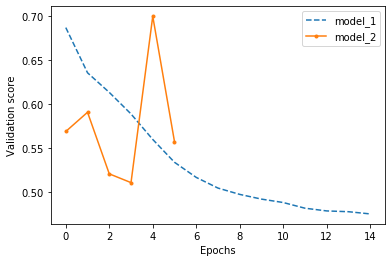

In [664]:
# Create the plot
#plt.plot(model_1_training.history['val_loss'], 'r', model_2_training.history['val_loss'], 'b')
plt.plot(model_1_training.history['val_loss'], linestyle='--', label='model_1')
plt.plot(model_2_training.history['val_loss'], marker='.', label='model_2')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

## Saving and reloading a model

In [250]:
model.save('model_file.h5')

In [252]:
my_model = keras.models.load_model('model_file.h5')

In [ ]:
predictions = my_model.predict()

In [ ]:
probability_true = predictions[:,1]